In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import os

# Complexity

In [2]:
# metric = 'mae' # ['mae', 'mse', 'r2', 'rmse']

In [3]:
complexity_dir = '/home/lmoroni/__workdir/augmenting_nlms_meco/output/complexity'
it_sentiment_dir = '../output/sentipolc/'
en_sentiment_dir = '/home/lmoroni/__workdir/augmenting_nlms_meco/output/sst2'

In [4]:
dir_names = os.listdir(complexity_dir)

In [5]:
def get_model_config(model_str):
    model_config = dict()
    model_str = model_str.split('_')
    model_config['language_mode'] = 'cross_lingual' if 'xlm' in model_str[0] else 'mono_lingual'
    if model_str[1] in ['en', 'it']:
        model_config['language'] = model_str[1]
        model_config['finetuned'] = False
        model_config['pretrained'] = True if model_str[2] == 'p' else False
        model_config['user'] = 0
        return model_config
    else:
        model_config['pretrained'] = True if model_str[1] == 'p' else False
        model_config['finetuned'] = True if model_str[2] == 'f' else False
        if model_config['finetuned']:
            model_config['language'] = model_str[-1][:2]
            model_config['user'] = int(model_str[-1][2:])
        else:
            model_config['language'] = 'en' if model_str[0] == 'roberta' else 'it'
            model_config['user'] = 0
        return model_config

In [6]:
def load_complexity_results(src_dir, metric='mae'):
    res_path = os.path.join(src_dir, 'all_results.json')
    with open(res_path, 'r') as res_file:
        res_dict = json.load(res_file)
    res = res_dict[f'test_{metric}']
    return res

In [7]:
def load_it_sentiment_results(src_dir, metric='accuracy'):
    res_path = os.path.join(src_dir, 'all_results.json')
    with open(res_path, 'r') as res_file:
        res_dict = json.load(res_file)
    res = res_dict[f'test_all_{metric}']
    return res

In [8]:
def load_en_sentiment_results(src_dir, metric='accuracy'):
    res_path = os.path.join(src_dir, 'all_results.json')
    with open(res_path, 'r') as res_file:
        res_dict = json.load(res_file)
    res = res_dict[f'test_{metric}']
    return res

In [9]:
def init_dict(model_config):
    all_dict = dict()
    for key in model_config:
        all_dict[key] = []
    all_dict['complexity'] = []
    all_dict['sentiment'] = []
    return all_dict

In [10]:
all_dict = None
for dir_name in dir_names:
    model_config = get_model_config(dir_name)
    if model_config['language'] == 'it':
        sentiment_res = load_it_sentiment_results(os.path.join(it_sentiment_dir, dir_name))
    else:
        sentiment_res = load_en_sentiment_results(os.path.join(en_sentiment_dir, dir_name))
    complexity_res = load_complexity_results(os.path.join(complexity_dir, dir_name))
    if all_dict is None:
        all_dict = init_dict(model_config)
    for key, value in model_config.items():
        all_dict[key].append(value)
    all_dict['complexity'].append(complexity_res)
    all_dict['sentiment'].append(sentiment_res)

In [11]:
all_df = pd.DataFrame.from_dict(all_dict)

In [12]:
all_df.head()

,language_mode,pretrained,finetuned,language,user,complexity,sentiment
0,cross_lingual,False,True,it,1,0.430066,0.702703
1,cross_lingual,False,False,en,0,0.351222,0.793578
2,cross_lingual,False,True,en,49,0.389413,0.788991
3,cross_lingual,True,True,it,44,0.413755,0.740240
4,mono_lingual,False,True,it,38,0.472675,0.729980


In [13]:
def get_sorted_index(index):
    str_values = ['avg_ft', 'no']
    int_values = [v for v in index.values.tolist() if v not in str_values]
    return sorted(int_values)+str_values

In [14]:
def get_model_str(language, language_mode, pretrained):
    pretrained_str = '_p' if pretrained else '_np'
    language_mode_str = '_ml' if language_mode == 'cross_lingual' else '' 
    return language+language_mode_str+pretrained_str

In [15]:
tasks = ['sentiment', 'complexity']

In [16]:
rows = {task: {'en':[], 'it':[]} for task in tasks}
for language in all_df['language'].unique():
    for language_mode in sorted(all_df['language_mode'].unique(), reverse=True):
        for pretrained in [True, False]:#all_df['pretrained'].unique():
            filtered_df = all_df[(all_df['language'] == language) & (all_df['language_mode'] == language_mode) & (all_df['pretrained'] == pretrained)].copy()
            filtered_df['fine-tuning'] = filtered_df.apply(lambda x: x['user'] if x['finetuned'] else 'no', axis=1)
            filtered_df = filtered_df[['complexity', 'sentiment', 'fine-tuning']]
            filtered_df = filtered_df.set_index('fine-tuning')
            filtered_df.loc['avg_ft'] = filtered_df[filtered_df.index != 'no'].mean()
            # row = #.T[get_sorted_index(filtered_df.index)]
            for task in tasks:
                row = filtered_df[[task]].rename(columns={task:get_model_str(language, language_mode, pretrained)})
                rows[task][language].append(row.T)

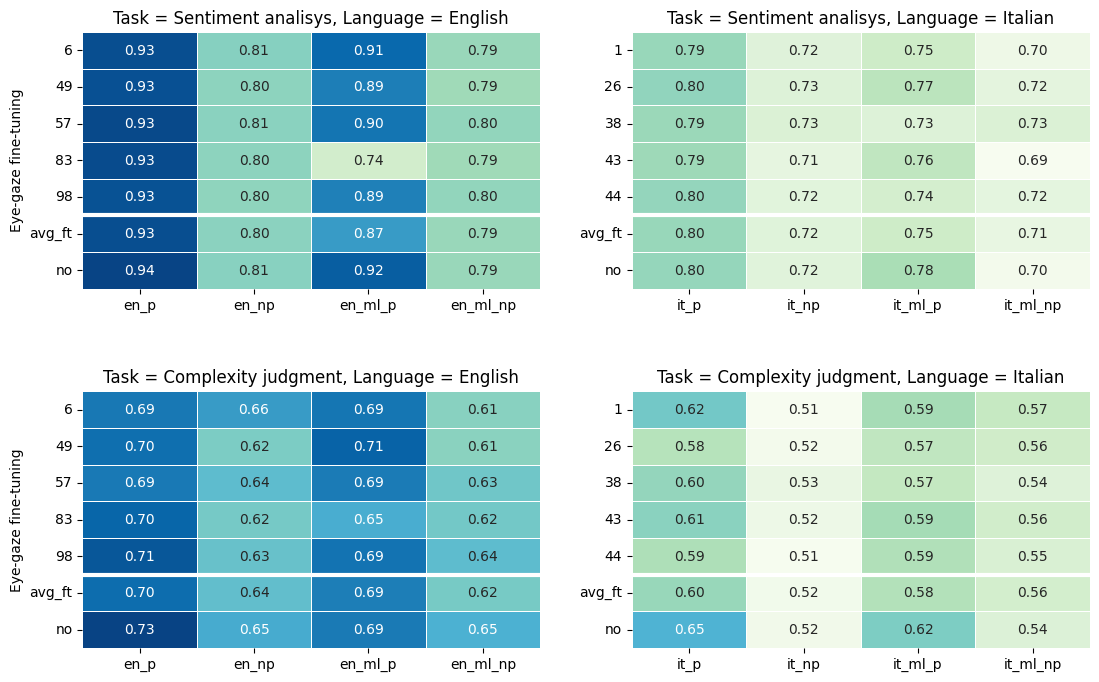

In [23]:
fig, axes = plt.subplots(2, 2,  figsize=(13, 8));
axes = axes.flatten();
plt.subplots_adjust(hspace=0.4);

ax_idx = 0

for task in tasks:
    for language in ['en', 'it']:
        df = pd.concat(rows[task][language])
        df = df[get_sorted_index(df.columns)]
        if task == 'complexity':
            df = df.map(lambda x: 1 - x)
            vmin = 0.51
            vmax = 0.73
        else:
            vmin = 0.69
            vmax = 0.94

        language_str = 'Italian' if language == 'it' else 'English'
        task_str = 'Sentiment analisys' if task == 'sentiment' else 'Complexity judgment'
        sns.heatmap(ax=axes[ax_idx], data=df.T, annot=True, fmt=".2f", cmap='GnBu', cbar=False, linewidth=.5, vmin=vmin, vmax=vmax).set_title(label=f'Task = {task_str}, Language = {language_str}');
        for tick in axes[ax_idx].get_yticklabels():
            tick.set_rotation(0)
        if language == 'en':
            axes[ax_idx].set(ylabel='Eye-gaze fine-tuning')
        else:
            axes[ax_idx].set(ylabel='')
        axes[ax_idx].hlines([5], *axes[ax_idx].get_xlim(), color='white', linewidths=3)
        ax_idx += 1

fig.savefig('/home/luca/Workspace/augmenting_nlms_meco/output/plots/downstream_tasks_finetuning_all.png', bbox_inches='tight')